# Модель классификации комментариев интернет-магазина

# 1. Подготовка

In [22]:
import re
import nltk
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import warnings
warnings.filterwarnings('ignore')

In [24]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [27]:
data.duplicated('toxic', keep=False).value_counts()

True    159571
dtype: int64

Датасет состоит из 159571 строки с данными о комментариях и признаком их токсичности. Пропусков и дубликатов нет.

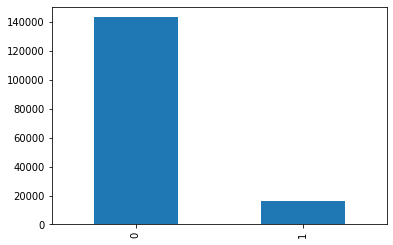

In [26]:
data['toxic'].value_counts().plot(kind='bar')

Наблюдаем дисбаланс классов, нетоксичных комментриев гораздо меньше токсичных.

Используя регулярные выражения отформатируем текст комментариев. Заменим используемые в английском языке сокращения на письме (апостровы), оставим только текст и пробелы.

In [28]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.split()
    return " ".join(text)

data['text'] = data['text'].map(lambda x : clear_text(x))

Определим стоп-слова, не несущие смысловой нагрузки для английского языка.

In [29]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Используем модель для деления 14:3:3 так как, помимо валидационной выборки выделяем так же тестовую выборку.

In [30]:
X = data.drop('toxic', axis=1)
y = data['toxic']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.3, shuffle=False)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, shuffle=False)

# 2. Обучение

#### Логистическая регрессия

In [28]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords)),
    ('model', LogisticRegression(random_state=12345))])

params = {'model__C': [0.1, 1, 10, 100],
          'model__class_weight': ['balanced', None]}

grid = GridSearchCV(estimator=pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid.fit(X_train['text'], y_train)
grid.best_params_

{'model__C': 10, 'model__class_weight': 'balanced'}

In [29]:
grid.best_score_

0.7647587768593782

In [39]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords)),
    ('model', LogisticRegression(random_state=12345, C = 10, class_weight = 'balanced'))])
pipe.fit(X_train['text'], y_train);
pred_valid = pipe.predict(X_valid['text'])
print('F1-score', f1_score(y_valid, pred_valid))

F1-score 0.7775343557060346


#### LightGBM

In [23]:
pipe1 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords)),
    ('model', lgb.LGBMClassifier(random_state=12345))])

params1 = {
  'model__n_estimators': [50, 100, 200],
  'model__learning_rate': [0.15, 0.25],
  'model__max_depth': [2, 5, 8]}

grid1 = GridSearchCV(estimator=pipe1, param_grid=params1, cv=3, scoring='f1', n_jobs=-1, refit=False)
grid1.fit(X_train['text'], y_train)
grid1.best_params_

{'model__learning_rate': 0.25,
 'model__max_depth': 8,
 'model__n_estimators': 200}

In [25]:
grid1.best_score_

0.7580089513273974

In [ ]:
pipe1 = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords)),
    ('model', lgb.LGBMClassifier(random_state=12345, n_estimators = 200, learning_rate = 0.25, max_depth = 8))])

pipe1.fit(X_train['text'], y_train);
pred_valid1 = pipe1.predict(X_valid['text'])
print('F1-score', f1_score(y_valid, pred_valid1))

# 3. Выводы

Большее значение метрики f1 мы наблюдаем на модели логистической регрессии, проверим ее работу на тестовой выборке:

In [40]:
pred_test = pipe.predict(X_test['text'])
print('F1-score', f1_score(y_test, pred_test))

F1-score 0.7737957610789981


Для магазина предлагаем использовать логистическую регрессию с гиперпараметрами random_state=12345, C = 10, class_weight = 'balanced' в качестве инструмента, который будет искать токсичные комментарии и отправлять их на модерацию.

При обучении модели удалось достичь значением метрики качества F1 равной 0.77 при проверке ее на тестовой выборке, что удовлетворяет требованиям заказчика.